In [1]:
import tensorflow as tf
import PIL
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.applications import mobilenet as _mobilenet
from keras_tqdm import TQDMNotebookCallback
import random

In [2]:
import numpy as np
def load_image(img_file, target_size=(224,224)):
    X = np.zeros((1, *target_size, 3))
    X[0, ] = np.asarray(tf.keras.preprocessing.image.load_img(
        img_file, 
        target_size=target_size)
    )
    X = tf.keras.applications.mobilenet.preprocess_input(X)
    return X

import os
def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [3]:
model = tf.keras.applications.mobilenet.MobileNet()
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [4]:
dog_image_id = os.listdir(r'F:\16 Artificial intelligence\CNN\cat and dog classification\train\dog')[0]
dog_image = load_image(os.path.join(r'F:\16 Artificial intelligence\CNN\cat and dog classification\train\dog',dog_image_id))
print(f'shape: {dog_image.shape}')
print(f'type: {type(dog_image)}')
model.predict(dog_image)

shape: (1, 224, 224, 3)
type: <class 'numpy.ndarray'>


array([[9.46676824e-04, 2.41357466e-05, 5.54305079e-05, 6.85645819e-06,
        1.08074200e-05, 2.46304262e-05, 3.62345850e-06, 2.19523642e-07,
        6.60083197e-06, 2.30766361e-07, 3.48655922e-05, 1.07115311e-05,
        2.74781019e-06, 4.42672717e-06, 2.35011589e-06, 3.53700216e-07,
        1.02673802e-07, 8.10185884e-06, 6.75070908e-07, 6.89058379e-06,
        5.59484512e-08, 1.38953499e-06, 1.00875809e-07, 2.93969748e-07,
        1.11121308e-05, 5.12499828e-05, 3.26636982e-05, 3.55413904e-05,
        1.41852233e-05, 8.34815728e-06, 2.00468162e-06, 3.29055229e-06,
        2.66703209e-05, 1.57387462e-04, 8.03301664e-05, 9.80207231e-04,
        7.97868634e-05, 1.54476438e-05, 3.77629772e-06, 1.02578042e-06,
        8.56076667e-07, 2.00609975e-05, 3.60089672e-07, 1.18349897e-06,
        1.05054933e-05, 1.32795105e-06, 5.31648425e-07, 6.53190500e-06,
        7.61353220e-08, 1.91629663e-08, 3.99632285e-07, 6.52811832e-06,
        3.27739399e-05, 1.53614441e-04, 3.84767845e-05, 3.281126

In [5]:
model = tf.keras.applications.mobilenet.MobileNet(
# The 3 is the three dimensions of the input: r,g,b.
  input_shape=(224, 224, 3), 
  include_top=False, 
  pooling='avg'
)

In [6]:
dog_image_id = os.listdir(r'F:\16 Artificial intelligence\CNN\cat and dog classification\train\dog')[0]
dog_image = load_image(os.path.join(r'F:\16 Artificial intelligence\CNN\cat and dog classification\train\dog',dog_image_id))
model.predict(dog_image).shape

(1, 1024)

In [7]:
x = Dropout(rate=0.4)(model.output)
x = Dense(2)(x)
x = Softmax()(x)
model= Model(model.inputs, x)

In [8]:
for layer in model.layers[:-3]:
    layer.trainable = False
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy'
)

In [18]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=_mobilenet.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

ensure_folder_exists('training_aug')
training = datagen.flow_from_directory( 
    r'F:\16 Artificial intelligence\CNN\cat and dog classification\train', 
    target_size=(224, 224),
    save_to_dir=r'F:\16 Artificial intelligence\CNN\cat and dog classification\training_aug',
    subset='training'
) 

ensure_folder_exists('validation_aug')
validation = datagen.flow_from_directory( 
    r'F:\16 Artificial intelligence\CNN\cat and dog classification\valid',
    target_size=(224, 224),
    save_to_dir=r'F:\16 Artificial intelligence\CNN\cat and dog classification\validation_aug',
    subset='validation'
) 

Found 330 images belonging to 2 classes.
Found 45 images belonging to 2 classes.


In [19]:
import os
from PIL import Image
folder_path = r'F:\16 Artificial intelligence\CNN\cat and dog classification\train'
extensions = []
for fldr in os.listdir(folder_path):
    sub_folder_path = os.path.join(folder_path, fldr)
    for filee in os.listdir(sub_folder_path):
        file_path = os.path.join(sub_folder_path, filee)
        print('** Path: {}  **'.format(file_path), end="\r", flush=True)
        im = Image.open(file_path)
        rgb_im = im.convert('RGB')
        if filee.split('.')[1] not in extensions:
            extensions.append(filee.split('.')[1])

In [43]:
batch_size = 32
history = model.fit(
    x=training,
    steps_per_epoch=training.samples // batch_size,
    epochs=30,
    validation_data=validation,
    validation_steps=validation.samples // batch_size
)

Epoch 1/30
10/10 [==============================] - 20s 2s/step - loss: 0.0837 - val_loss: 0.0503
Epoch 2/30
10/10 [==============================] - 16s 2s/step - loss: 0.0959 - val_loss: 0.0788
Epoch 3/30
10/10 [==============================] - 17s 2s/step - loss: 0.1010 - val_loss: 0.0697
Epoch 4/30
10/10 [==============================] - 15s 2s/step - loss: 0.0947 - val_loss: 0.0551
Epoch 5/30
10/10 [==============================] - 15s 2s/step - loss: 0.0812 - val_loss: 0.0683
Epoch 6/30
10/10 [==============================] - 16s 2s/step - loss: 0.0847 - val_loss: 0.0461
Epoch 7/30
10/10 [==============================] - 16s 2s/step - loss: 0.1137 - val_loss: 0.0412
Epoch 8/30
10/10 [==============================] - 17s 2s/step - loss: 0.0726 - val_loss: 0.0541
Epoch 9/30
10/10 [==============================] - 16s 2s/step - loss: 0.0627 - val_loss: 0.0317
Epoch 10/30
10/10 [==============================] - 16s 2s/step - loss: 0.0785 - val_loss: 0.0519
Epoch 11/30
10/10 [

In [38]:
path_1 = r'F:\16 Artificial intelligence\CNN\cat and dog classification\test\p1.jpg'
path_2 = r'F:\16 Artificial intelligence\CNN\cat and dog classification\test\p2.jpg'
path_3 = r'F:\16 Artificial intelligence\CNN\cat and dog classification\test\p3.jpg'
path_4 = r'F:\16 Artificial intelligence\CNN\cat and dog classification\test\p4.jpg'
path_5 = r'F:\16 Artificial intelligence\CNN\cat and dog classification\test\p5.jpg'


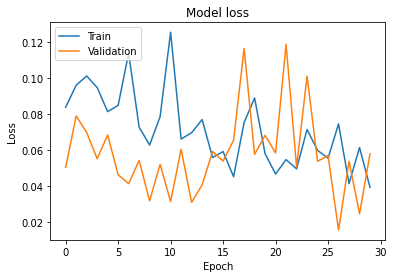

In [44]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

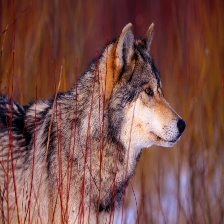

In [31]:
p3 = load_image(path_3)
tf.keras.preprocessing.image.load_img(path_3, target_size=(224,224))

In [30]:
print(f'''p3:{np.round(model.predict(p3),2)}''')

p3:[[0.07 0.93]]


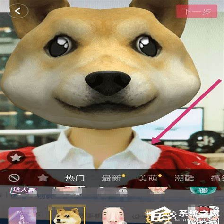

In [32]:
p4 = load_image(path_4)
tf.keras.preprocessing.image.load_img(path_4, target_size=(224,224))

In [33]:
print(f'''p4:{np.round(model.predict(p4),2)}''')

p4:[[0.03 0.97]]


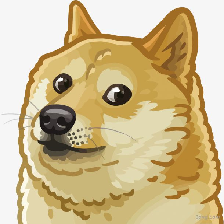

In [39]:
p5 = load_image(path_5)
tf.keras.preprocessing.image.load_img(path_5, target_size=(224,224))

In [40]:
print(f'''p5:{np.round(model.predict(p5),2)}''')

p5:[[0.06 0.94]]


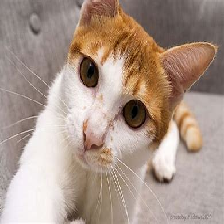

In [37]:
p1 = load_image(path_1)
tf.keras.preprocessing.image.load_img(path_1, target_size=(224,224))

In [36]:
print(f'''p1:{np.round(model.predict(p1),2)}''')

p1:[[1. 0.]]
